Progress Report 4: Enhanced CNN with Adaptive Denoising and Augmentation for Improved Bounding Box Predictions

Enhanced model complexity with additional layers and enchanced the denosing

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

2024-12-05 17:39:11.175645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Loading and Preprocessing with Diverse Augmentation

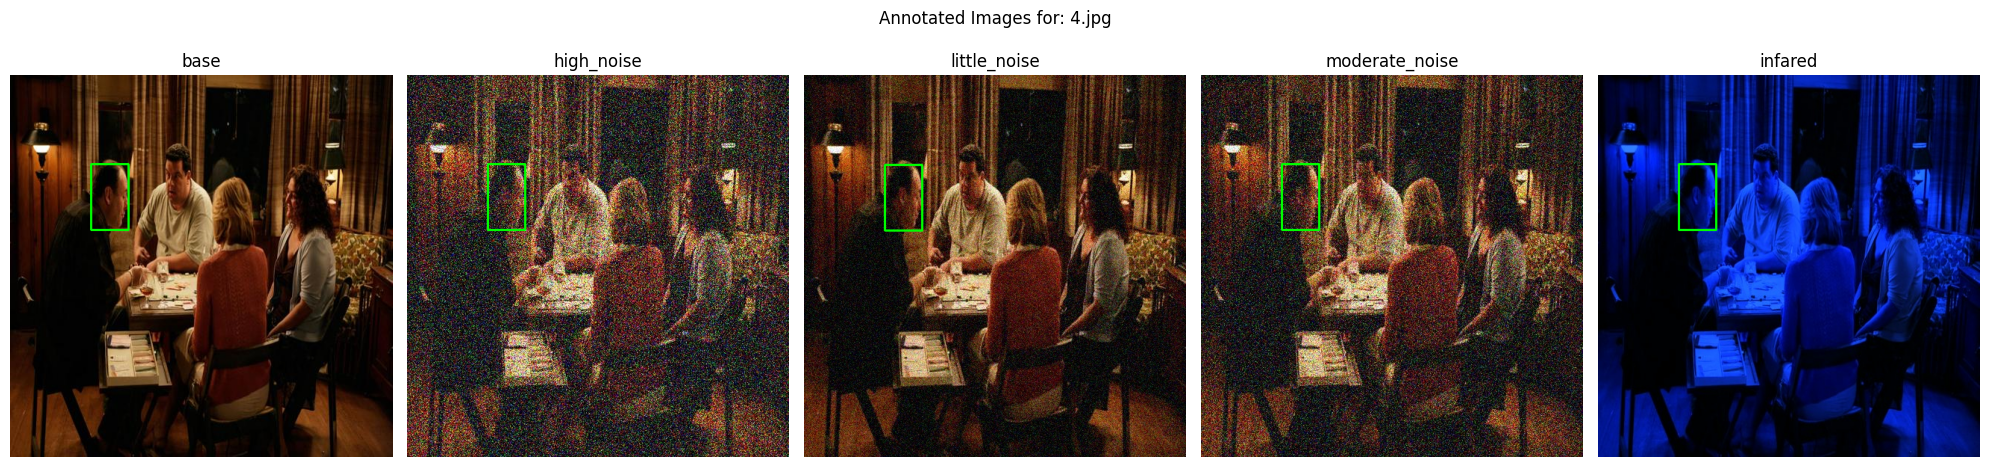

In [2]:
import os
import cv2
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = './new_data/resized_images'
NOISE_FOLDERS = ['high_noise', 'little_noise', 'moderate_noise', 'infared']
annotation_file = os.path.join(BASE_DIR, 'combined_annotations.csv')

# Function to load a single image and its annotation
def load_image_with_annotation(base_dir, noise_folders, annotation_file):
    annotations = pd.read_csv(annotation_file)
    row = random.choice(annotations.to_dict(orient='records'))  # Randomly pick an annotation row
    
    img_filename = row['filename']
    bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    
    images_with_noise = {}
    for noise_folder in ['base'] + noise_folders:
        img_path = os.path.join(base_dir, noise_folder, img_filename) if noise_folder != 'base' else os.path.join(base_dir, img_filename)
        
        if os.path.exists(img_path):
            image = cv2.imread(img_path)
            if image is not None:
                images_with_noise[noise_folder] = (cv2.resize(image, (512, 512)), bbox)
    
    return images_with_noise, img_filename

# Plotting the image with bounding boxes
def plot_annotated_images(images_with_noise, filename):
    num_images = len(images_with_noise)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    if num_images == 1:
        axes = [axes]  # Ensure axes is always iterable for single images
    
    for ax, (noise_type, (image, bbox)) in zip(axes, images_with_noise.items()):
        # Draw bounding box on image
        annotated_image = image.copy()
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(annotated_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        ax.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        ax.set_title(noise_type)
        ax.axis('off')
    
    plt.suptitle(f"Annotated Images for: {filename}")
    plt.tight_layout()
    plt.show()

# Load and plot
images_with_noise, filename = load_image_with_annotation(BASE_DIR, NOISE_FOLDERS, annotation_file)
plot_annotated_images(images_with_noise, filename)


In [3]:
BASE_DIR = './new_data/resized_images'
NOISE_FOLDERS = ['high_noise', 'little_noise', 'moderate_noise', 'infared']
annotation_file = os.path.join(BASE_DIR, 'combined_annotations.csv')

def load_data_with_noise(annotation_file, base_dir=BASE_DIR, noise_folders=NOISE_FOLDERS):
    annotations = pd.read_csv(annotation_file)
    images = []
    labels = []
    image_types = []
    source_counts = {folder: 0 for folder in noise_folders}
    source_counts['train_data'] = 0
    source_counts[os.path.basename(base_dir)] = 0  

    for _, row in annotations.iterrows():
        img_filename = row['filename']
        folder_choice = random.choice([base_dir] + [os.path.join(base_dir, folder) for folder in noise_folders])
        img_path = os.path.join(folder_choice, img_filename)
        
        if not os.path.exists(img_path):
            img_path = os.path.join(base_dir, img_filename)
            source_counts['train_data'] += 1
            image_type = 'base'
        else:
            folder_key = os.path.basename(folder_choice)
            source_counts[folder_key] += 1
            image_type = folder_key
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (512, 512))
            images.append(image[..., np.newaxis])
            labels.append([row['xmin'] / 512, row['ymin'] / 512, row['xmax'] / 512, row['ymax'] / 512])
            image_types.append(image_type)
    
    print("Data loaded from each source:", source_counts)
    return np.array(images) / 255.0, np.array(labels), image_types

images, labels, image_types = load_data_with_noise(annotation_file)
x_train, x_test, y_train, y_test, train_types, test_types = train_test_split(
    images, labels, image_types, test_size=0.2, random_state=42)

print(f'Training samples: {x_train.shape[0]}, Testing samples: {x_test.shape[0]}')


Data loaded from each source: {'high_noise': 31, 'little_noise': 21, 'moderate_noise': 24, 'infared': 20, 'train_data': 0, 'resized_images': 29}
Training samples: 100, Testing samples: 25


Adaptive Denoising Layer

In [4]:

denoised_count = tf.Variable(0, trainable=False, dtype=tf.int32)

def adaptive_denoise_layer(inputs):
    @tf.function
    def denoise(image):
        # Calculate variance (or other noise metric)
        variance = tf.math.reduce_variance(image)
        
        # Define a noise threshold
        threshold = 0.1  # Adjust this value based on your data
        
        # Smoothing filter
        smoothing_filter = tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)
        smoothing_filter = smoothing_filter / tf.reduce_sum(smoothing_filter)

        smoothed_image = tf.nn.conv2d(tf.expand_dims(image, 0),
                                      filters=smoothing_filter[..., tf.newaxis, tf.newaxis],
                                      strides=[1, 1, 1, 1], padding='SAME')
        smoothed_image = tf.squeeze(smoothed_image, axis=0)

        # Apply denoising conditionally
        condition = variance > threshold
        is_denoised = tf.cast(condition, tf.int32)
        denoised_count.assign_add(is_denoised)

        return tf.where(condition, smoothed_image, image)

    denoised_count.assign(0)

    # Apply the denoise function to each input
    result = tf.map_fn(denoise, inputs)
    return result

Building and Compiling the Enhanced CNN Model

In [5]:
def create_model(input_shape=(512, 512, 1)):  
    inputs = Input(shape=input_shape)
    x = Lambda(adaptive_denoise_layer, output_shape=input_shape)(inputs)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    
    outputs = Dense(4, activation='linear')(x)

 
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model


class DenoiseCountCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.total_denoised = 0
        self.total_images = 0

    def on_batch_end(self, batch, logs=None):
       
        batch_size = logs.get("size", 0)
        self.total_images += batch_size
        self.total_denoised += int(denoised_count.numpy())

    def on_epoch_end(self, epoch, logs=None):
        
        print(f"\nEnd of epoch {epoch + 1}: Denoised images = {self.total_denoised}")
        
        self.total_denoised = 0
        self.total_images = 0


model = create_model()

Training the Enhanced Model

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    zoom_range=0.1,       
    shear_range=0.1       
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=10),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[DenoiseCountCallback()]
)

/Users/anthonydibenedetto/opt/anaconda3/envs/MachineLearning/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1701 - mae: 0.3479
End of epoch 1: Denoised images = 0
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.1686 - mae: 0.3460 - val_loss: 0.0260 - val_mae: 0.1278
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0471 - mae: 0.1696
End of epoch 2: Denoised images = 0
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0468 - mae: 0.1692 - val_loss: 0.0350 - val_mae: 0.1550
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0356 - mae: 0.1534
End of epoch 3: Denoised images = 0
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0354 - mae: 0.1526 - val_loss: 0.0326 - val_mae: 0.1435
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0316 - mae: 0.1371
End of epoch 4: Denoised images = 0
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0317 - mae: 0.1376 - val_loss: 0.0244 - val_mae: 0.1276
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0285 - mae: 0.1362
End of epoch 5: Denoised images = 0
10/10 ━━━━

Testing and Enhanced Visualization of Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


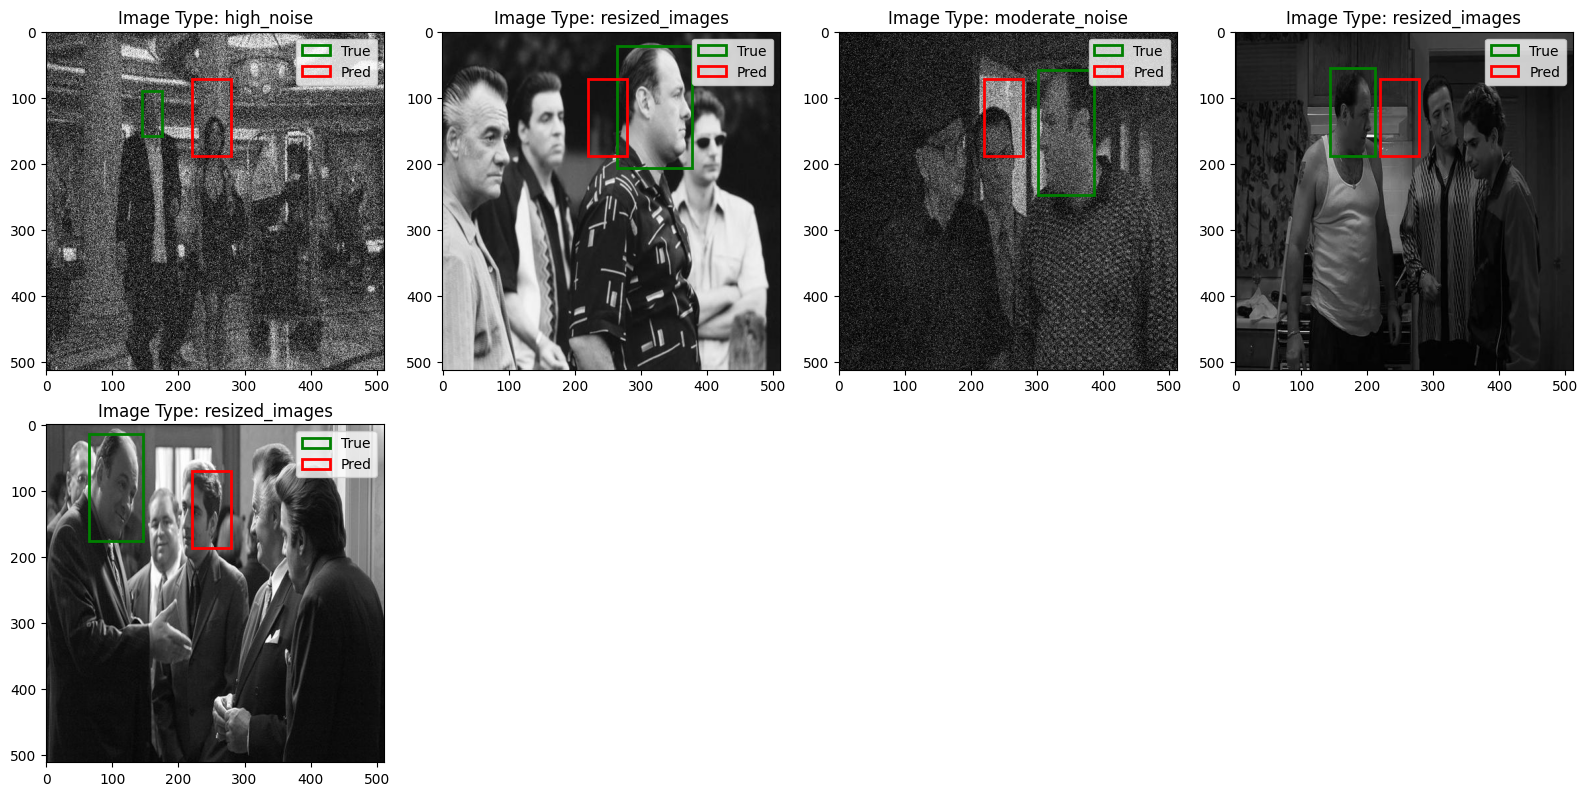

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_predictions(x_test, y_test, test_types, model, indices=None, show_index=False, max_images_per_row=3):
    preds = model.predict(x_test) * 512  # Scale predictions back to pixel values
    y_test = y_test * 512  # Scale ground truth labels back to pixel values
    
    # Use specified indices if provided, else default to the first 5 indices
    if indices is None:
        indices = range(min(5, len(x_test)))
    
    num_images = len(indices)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Calculate required rows
    
    plt.figure(figsize=(max_images_per_row * 4, num_rows * 4))  # Adjust figure size
    
    for i, idx in enumerate(indices):
        if idx >= len(x_test):  # Ensure index is within bounds
            print(f"Index {idx} is out of bounds for x_test with length {len(x_test)}")
            continue

        rgb_image = cv2.cvtColor((x_test[idx] * 255).astype(np.uint8).squeeze(), cv2.COLOR_GRAY2RGB)
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(rgb_image)
        
        # Display title with optional index
        title = f'Image Type: {test_types[idx]}'
        if show_index:
            title = f'Index {idx} - ' + title
        plt.title(title)
        
        # Draw true bounding box (green)
        plt.gca().add_patch(
            plt.Rectangle((y_test[idx][0], y_test[idx][1]), y_test[idx][2] - y_test[idx][0], y_test[idx][3] - y_test[idx][1],
                          edgecolor='g', lw=2, fill=False, label='True')
        )
        
        # Draw predicted bounding box (red)
        plt.gca().add_patch(
            plt.Rectangle((preds[idx][0], preds[idx][1]), preds[idx][2] - preds[idx][0], preds[idx][3] - preds[idx][1],
                          edgecolor='r', lw=2, fill=False, label='Pred')
        )
        
        plt.legend(['True', 'Pred'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage with optional flags and max_images_per_row adjustment
visualize_predictions(x_test, y_test, test_types, model, indices=[1,2,3,4,5], show_index=False, max_images_per_row=4)


In [ ]:
def plot_loss_graph(history):
    """
    Plots the training and validation loss curves.

    Args:
        history: The history object returned by the `model.fit()` function, containing training and validation loss.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,10)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


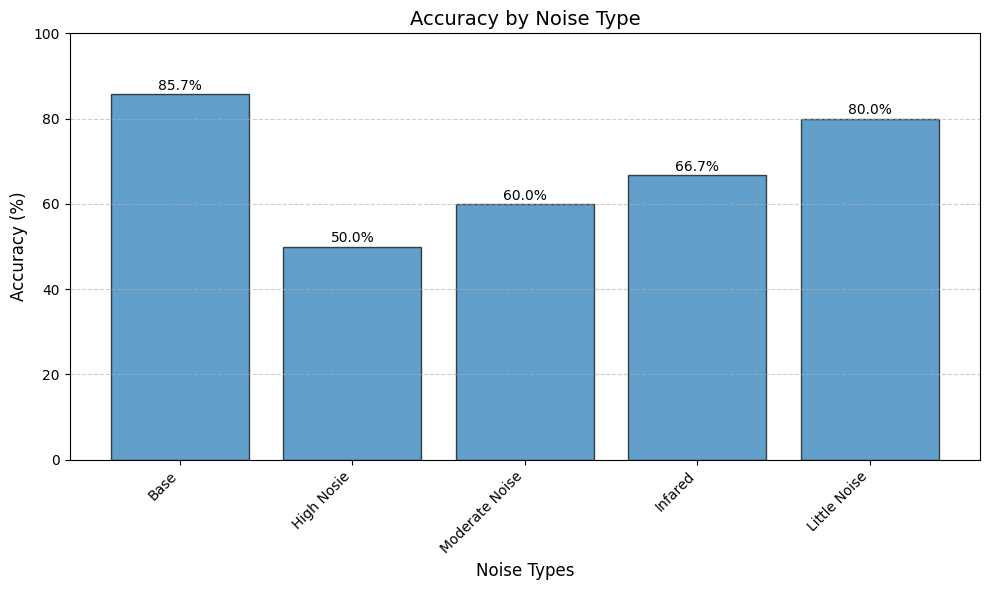

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

predictions = model.predict(x_test) * 512  
ground_truth = y_test * 512 

def calculate_accuracy(predictions, ground_truth, types, margin=10):
    noise_types = set(types)
    accuracy_results = {}

    for noise in noise_types:
        noise_indices = [i for i, t in enumerate(types) if t == noise]
        pred_subset = predictions[noise_indices]
        gt_subset = ground_truth[noise_indices]

        correct = sum((np.abs(pred - gt) <= margin).all() for pred, gt in zip(pred_subset, gt_subset))
        accuracy = correct / len(noise_indices)
        accuracy_results[noise] = accuracy * 100 

    return accuracy_results
accuracy_results = calculate_accuracy(predictions, ground_truth, test_types, margin=80)

def plot_accuracy(accuracy_results):
    plt.figure(figsize=(10, 6))
    
    noise_types = list(accuracy_results.keys())
    accuracies = list(accuracy_results.values())

    plt.bar(noise_types, accuracies, alpha=0.7, edgecolor='black')
    plt.xlabel('Noise Types', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Accuracy by Noise Type', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    xtick_positions = np.arange(len(noise_types))  
    custom_labels = ["Base", "High Nosie", "Moderate Noise", "Infared", "Little Noise"]  

    plt.xticks(ticks=xtick_positions, labels=custom_labels, rotation=45, ha='right', fontsize=10)

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_accuracy(accuracy_results)
